In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os 
import pickle
import sys 
import time
import tqdm

sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel
%matplotlib inline

In [2]:
mpl_params = {'legend.fontsize': 14,
              'legend.frameon': False,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

### Load trained NB posterior

In [3]:
folder = '../data/'
fn = 'learned_posterior_nbmodel_ntrain100000.p'
time_stamp = time.strftime('%Y%m%d%H%M_')

with open(os.path.join(folder, fn), 'rb') as f: 
    d = pickle.load(f)
    
# set the seed for generating new test data 
seed = 3
np.random.seed(seed)

In [4]:
# priors 
prior_k = d['prior_k']
prior_theta = d['prior_theta']
sample_size = d['sample_size']
ntrain = d['ntrain']
param_norm = d['param_norm']
data_norm = d['data_norm']

model_nb = d['model']
model_params_mdn = d['mdn']
loss_trace = d['trainer'].loss_trace

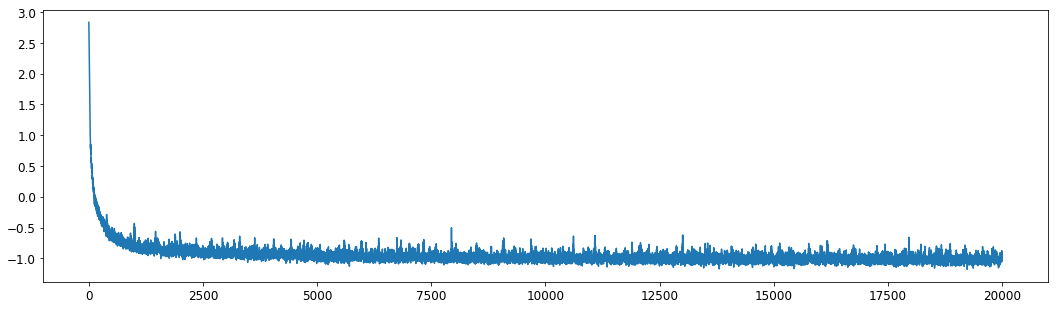

In [5]:
plt.figure(figsize=(18, 5))
plt.plot(loss_trace);

## Sample new test data 

In [8]:
ntest = 500
params_test = np.vstack((prior_k.rvs(size=ntest), prior_theta.rvs(size=ntest))).T
x_test = model_nb.gen(params_test)

In [9]:
sx_test = calculate_stats_toy_examples(x_test)
sx_test_zt, _ = normalize(sx_test, data_norm)
params_test_zt, _ = normalize(params_test, param_norm)

## Loop over test samples for 
- #### Quantiles 
- #### posterior mean differences 
- #### $D_{KL}$
- #### credible intervals 

In [15]:
# quantiles, dkl ratios and credible intervals for every dimension (2)
dkl_ratios = np.zeros((3, ntest))

qis = np.zeros_like(dkl_ratios)
qis_hat = np.zeros_like(dkl_ratios)

mus_hat = np.zeros_like(dkl_ratios)
mus_exact = np.zeros_like(dkl_ratios)
stds_hat = np.zeros_like(dkl_ratios)
stds_exact = np.zeros_like(dkl_ratios)

credible_intervals = np.arange(0.05, 1., 0.05)
marginal_ci_counts = np.zeros((2, ntest, credible_intervals.size))
marginal_ci_counts_hat = np.zeros((2, ntest, credible_intervals.size))

covariances = []
covariances_hat = []

ms = []
ms_hat = []
ps = []
ps_hat = []

priors = [prior_k, prior_theta]
joint_prior = JointGammaPrior(prior_k, prior_theta)
# for every test sample 
fails = []

with tqdm.tqdm(total=ntest) as pbar: 
    for ii, (thetao_i, sxo_i, xo_i) in enumerate(zip(params_test, sx_test_zt, x_test)): 

        # predict the posterior
        post_hat_zt = model_params_mdn.predict(sxo_i.reshape(1, -1))
        dd = post_hat_zt.get_dd_object()
        # transform back to original parameter range
        post_hat = post_hat_zt.ztrans_inv(param_norm[0], param_norm[1])
        marginals_hat = post_hat.get_marginals()
        
        # the exact posterior 
        post_exact = NBExactPosterior(xo_i, prior_k, prior_theta)
        post_exact.calculat_exact_posterior(theta_o=thetao_i, verbose=False, prec=1e-7, n_samples=400)
        
        marginals_exact = post_exact.get_marginals()
        ps.append(post_exact)
        ps_hat.append(post_hat)
        ms.append(marginals_exact)
        ms_hat.append(marginals_hat)
       
        try:
            pbar.update()
            # perform check for marginals         
            for vi, (m, mhat, th) in enumerate(zip(marginals_exact, marginals_hat, thetao_i)):             
                # means and std 
                # generate samples for estimating the mean and std
                ss = m.gen(10000)
                mus_exact[vi, ii], stds_exact[vi, ii] = m.mean, m.std
                mus_hat[vi, ii], stds_hat[vi, ii] = mhat.mean, mhat.std

                # quantiles 
                qis[vi, ii] = m.cdf(th)
                qis_hat[vi, ii] = mhat.get_quantile(th)

                # credible intervals
                marginal_ci_counts[vi, ii, :] = m.get_credible_interval_counts(th, credible_intervals)
                marginal_ci_counts_hat[vi, ii, :] = mhat.get_credible_interval_counts(th, credible_intervals)

                # DKL 
                baseline = calculate_dkl_1D_scipy(m.pdf_array, priors[vi].pdf(m.support))
                (dkl, err) = calculate_dkl_monte_carlo(np.array(ss), m.pdf, mhat.eval_numpy)
                dkl_ratios[vi, ii] = dkl / baseline

            # perform checks for joint 
            vi = 2

            # quantiles 
            qis[vi, ii] = post_exact.cdf(thetao_i.reshape(1, -1))
            qis_hat[vi, ii] = post_hat.get_quantile(thetao_i.reshape(1, -1))

            # DKL 
            post_samples = post_exact.gen(20000)
            (baseline, err) = calculate_dkl_monte_carlo(post_samples, post_exact.pdf, joint_prior.pdf)
            (dkl, err) = calculate_dkl_monte_carlo(post_samples, post_exact.pdf, post_hat.eval_numpy)
            dkl_ratios[vi, ii] = dkl / baseline

            # covariances
            covariances.append(post_exact.cov)
            covariances_hat.append(post_hat.get_covariance_matrix())     
        except:
            fails.append(ii)
            continue
fails

  0%|          | 1/500 [00:46<6:26:28, 46.47s/it]../../model_comparison/utils.py:662: RuntimeWarning: divide by zero encountered in log
  value = np.log(nbinom_pmf(x, r, p)).sum() + np.log(pr) + np.log(pp)
100%|██████████| 500/500 [7:00:52<00:00, 45.19s/it]    


[]

In [16]:
# save posterior checks results 
result_dict = dict(qis=qis, qis_hat=qis_hat, dkl_ratios=dkl_ratios,
                  marginal_ci_counts=marginal_ci_counts, 
                  marginal_ci_counts_hat=marginal_ci_counts_hat, 
                  fails=fails, 
                  ntest=ntest, 
                  mus_exact=mus_exact, mus_hat=mus_hat, 
                  stds_exact=stds_exact, stds_hat=stds_hat, 
                  credible_intervals=credible_intervals, 
                  covariances=covariances, 
                  covariances_hat=covariances_hat, 
                  params_test=params_test, 
                  sx_test_zt=sx_test_zt, 
                  x_test=x_test, 
                  ps=ps, 
                  p_hats=ps_hat)

fn = time_stamp + 'posterior_checks_results_NB_ntrain{}_ns{}_ntest{}'.format(ntrain, sample_size, ntest) + '.p'
with open(os.path.join('../data', fn), 'wb') as outfile: 
    pickle.dump(result_dict, outfile, pickle.HIGHEST_PROTOCOL)

In [ ]:
2